##### Problem Descritpion 

Create a Machine Learning model able to accurately predict apartment price given a set of attributes defining the property. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

sns.set()

In [2]:
data = pd.read_csv("TradusChallenge/tradus_challenge_data.csv")

print(data.shape, data.columns)


(67107, 6) Index(['neighbourhood', 'price', 'size', 'bedrooms', 'bathrooms', 'building'], dtype='object')


# EDA

#### Assumptions

- The houses are priced in Euros

In [3]:
data.head(20)

,neighbourhood,price,size,bedrooms,bathrooms,building
0,SNR,130000.0,1300.0,2,3.0,Building_263
1,ZMS,140000.0,1185.0,1,2.0,Building_25
2,ZMS,250000.0,2050.0,3,5.0,Building_324
3,ZMS,250000.0,3860.0,4,5.0,Building_353
4,SNR,170000.0,1896.0,3,4.0,Building_280
5,ZMS,110000.0,850.0,1,2.0,Building_101
6,PLY,60000.0,520.0,0,1.0,Building_173
7,ZMS,80000.0,770.0,1,1.0,Building_185
8,ZMS,85000.0,684.0,1,2.0,Building_180
9,ZMS,95000.0,700.0,0,1.0,Building_76


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67107 entries, 0 to 67106
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   price          67107 non-null  float64
 2   size           67107 non-null  float64
 3   bedrooms       67107 non-null  int64  
 4   bathrooms      63657 non-null  float64
 5   building       61068 non-null  object 
dtypes: float64(3), int64(1), object(2)
memory usage: 3.1+ MB


In [5]:
data.isnull().sum()

neighbourhood       0
price               0
size                0
bedrooms            0
bathrooms        3450
building         6039
dtype: int64

In [6]:
data[data["bathrooms"].isnull()]

,neighbourhood,price,size,bedrooms,bathrooms,building
13,ZMS,120000.0,931.0,1,NaN,Building_353
22,ZMS,115000.0,890.0,1,NaN,Building_353
27,ZMS,200000.0,2633.0,3,NaN,Building_193
32,ZMS,325000.0,3227.0,4,NaN,Building_24
61,ZMS,130000.0,1736.0,2,NaN,Building_305
...,...,...,...,...,...,...
67029,ZMS,155000.0,1350.0,2,NaN,Building_101
67040,PLY,120000.0,1300.0,2,NaN,Building_123
67073,ZMS,140000.0,1260.0,2,NaN,Building_323
67079,SNR,170995.0,1950.0,3,NaN,Building_284


In [7]:
data["bathrooms"] = data["bathrooms"].fillna(0)

In [8]:
X = data.copy(deep = True).drop("price", axis = 1)
y = data.copy(deep = True)[["price"]]/1000 # the number are quite large, convert the unit to 1000 Euro



### EDA of target variable price


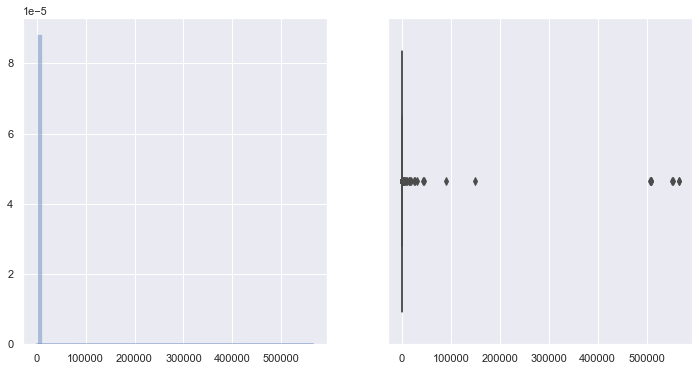

In [9]:
fig, ax = plt.subplots(ncols = 2, figsize=(12,6))
sns.distplot(y[["price"]], ax = ax[0])
sns.boxplot(y[["price"]], ax = ax[1])

#### Assumption (business rules to detect valid and invalid data)

If a domain expert were available these business rules would be checked and adjusted as neccessary. For now an assumption a reasonable cut off price will be made. Using the analysis below this cutoff is set at in order to retain as much data as possible while removing data that looks like it can't be valid.

In [10]:
y.describe()

,price
count,67107.000000
mean,219.911781
std,5882.341621
min,22.000000
25%,99.000000
50%,130.000000
75%,165.000000
max,565352.964000


In [11]:
threshold = 165+1.5*(165-99)

In [12]:
y_clean = y[y["price"] <= threshold]

In [13]:
y_clean.describe()

,price
count,64216.000000
mean,132.699475
std,45.142232
min,22.000000
25%,95.000000
50%,125.000000
75%,160.000000
max,262.500000


In [14]:
print(f"Data loss {y.shape[0]-y_clean.shape[0]} ({(y.shape[0]-y_clean.shape[0])/y.shape[0]})")


Data loss 2891 (0.04308045360394594)


## Data Feature Analysis

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67107 entries, 0 to 67106
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   neighbourhood  67107 non-null  object 
 1   size           67107 non-null  float64
 2   bedrooms       67107 non-null  int64  
 3   bathrooms      67107 non-null  float64
 4   building       61068 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 2.6+ MB


In [16]:
X = X.drop("building", axis = 1)

In [17]:
X.describe()

,size,bedrooms,bathrooms
count,6.710700e+04,67107.000000,67107.000000
mean,1.621593e+03,1.654969,2.279524
std,9.049481e+03,1.008304,1.175827
min,-7.550000e+02,0.000000,0.000000
25%,8.400000e+02,1.000000,2.000000
50%,1.200000e+03,2.000000,2.000000
75%,1.637000e+03,2.000000,3.000000
max,1.170000e+06,12.000000,12.000000


In [18]:
X_clean = X[y["price"] <= threshold]

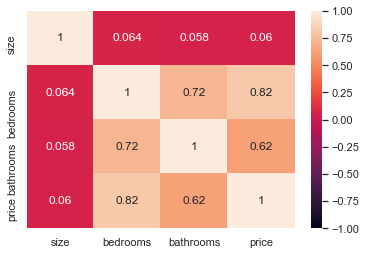

In [19]:
clean_data = pd.concat([X_clean,y_clean], axis =1)
sns.heatmap(clean_data.corr(),vmin=-1,vmax=1,annot=True)

### Neighbourhood

In [20]:
X_clean["neighbourhood"].value_counts()

ZMS    33681
PLY    20594
SNR     9941
Name: neighbourhood, dtype: int64

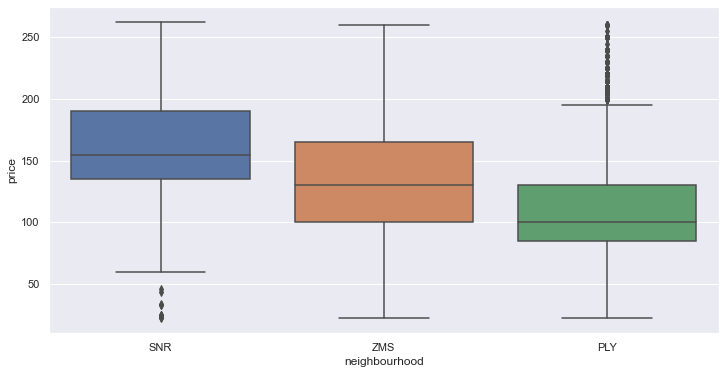

In [21]:
fix, ax = plt.subplots(figsize = (12,6))
sns.boxplot(X_clean["neighbourhood"], y_clean['price'])


### Bedrooms

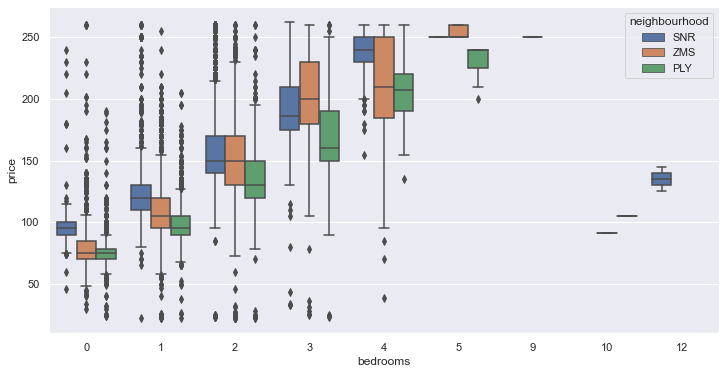

In [22]:
plt.figure(figsize=(12,6))
sns.boxplot(data=clean_data, x = "bedrooms", y="price", hue = "neighbourhood")


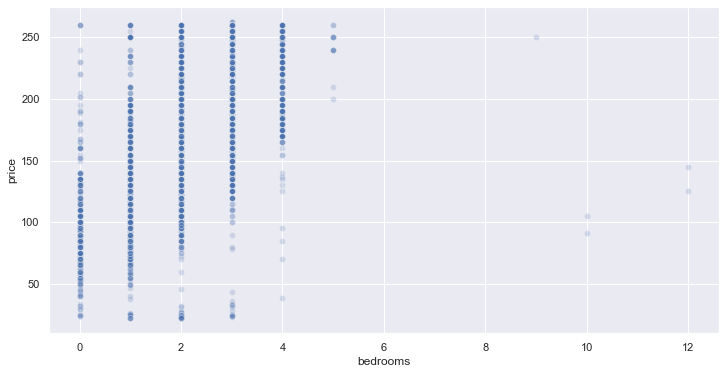

In [23]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=clean_data, x = "bedrooms", y="price", alpha = 0.2)

In [24]:
clean_data.loc[clean_data["bedrooms"] > 6]

,neighbourhood,size,bedrooms,bathrooms,price
3048,SNR,1200.0,12,0.0,125.00
11394,ZMS,1700.0,9,0.0,250.00
40065,SNR,1430.0,12,2.0,145.00
49603,PLY,405.0,10,6.0,105.04
59012,ZMS,867.0,10,2.0,91.00


### Bathrooms

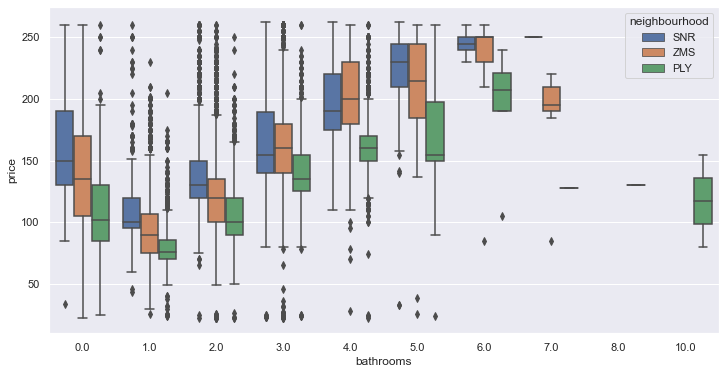

In [25]:
plt.figure(figsize=(12,6))
sns.boxplot(data=clean_data, x = "bathrooms", y="price", hue = "neighbourhood")

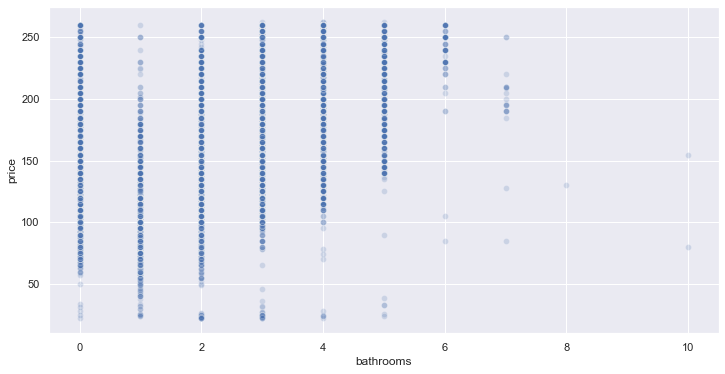

In [26]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=clean_data, x = "bathrooms", y="price", alpha = 0.2)

In [27]:
clean_data.loc[clean_data["bathrooms"] > 6]

,neighbourhood,size,bedrooms,bathrooms,price
2838,ZMS,4350.0,4,7.0,190.0
3915,ZMS,4350.0,4,7.0,196.0
4574,ZMS,4350.0,4,7.0,190.0
6533,PLY,500.0,0,10.0,80.0
6606,PLY,1966.0,2,10.0,155.0
9766,PLY,1300.0,2,7.0,128.0
13258,SNR,2800.0,4,7.0,250.0
16043,ZMS,2700.0,3,7.0,210.0
16921,SNR,2800.0,4,7.0,250.0
20281,ZMS,4300.0,4,7.0,210.0


### Size

In [28]:
(clean_data["size"]).describe()

count    6.421600e+04
mean     1.473754e+03
std      8.861915e+03
min     -7.550000e+02
25%      8.200000e+02
50%      1.182000e+03
75%      1.550000e+03
max      1.170000e+06
Name: size, dtype: float64

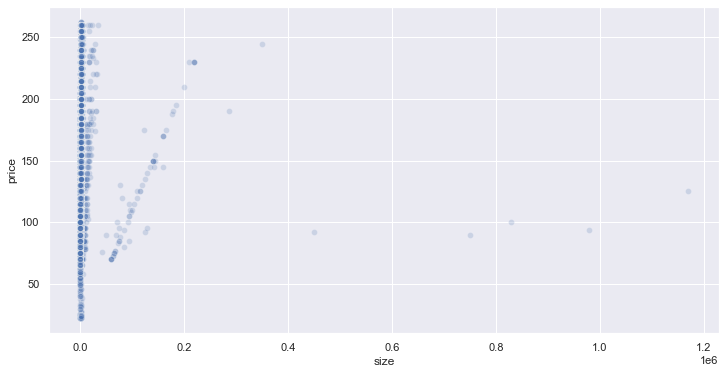

In [29]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = clean_data["size"], y=clean_data["price"], alpha = 0.2)

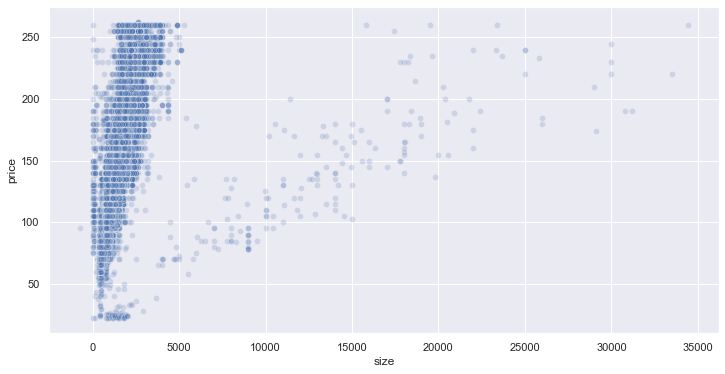

In [30]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = clean_data.loc[clean_data["size"] <= 40_000]["size"], y=clean_data.loc[clean_data["size"] <= 40_000]["price"], alpha = 0.2)



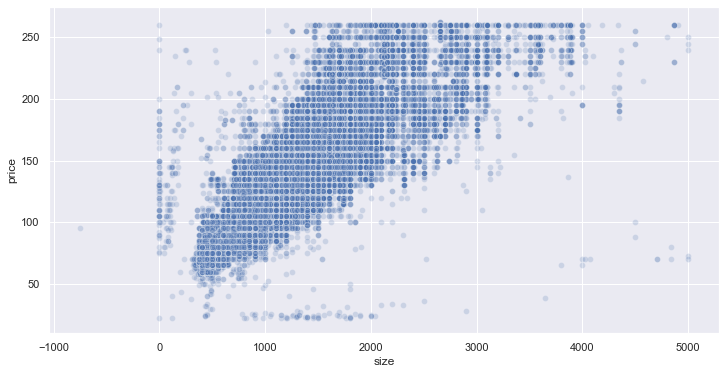

In [31]:

plt.figure(figsize=(12,6))
sns.scatterplot(x = clean_data.loc[clean_data["size"] <= 5_000]["size"], y=clean_data.loc[clean_data["size"] <= 5_000]["price"], alpha = 0.2)



### MultiVariate 

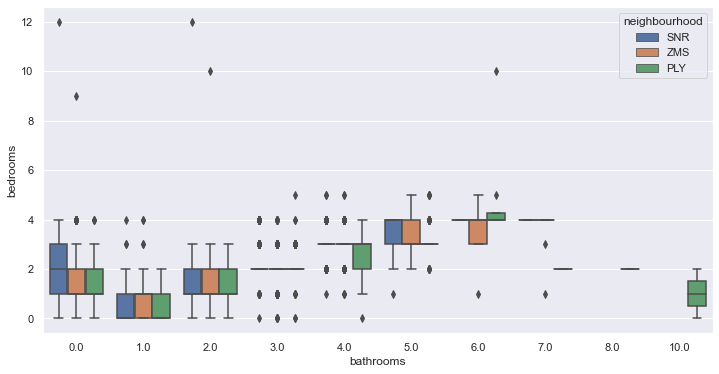

In [32]:
plt.figure(figsize=(12,6))
sns.boxplot(data=clean_data, x = "bathrooms", y="bedrooms", hue = "neighbourhood")

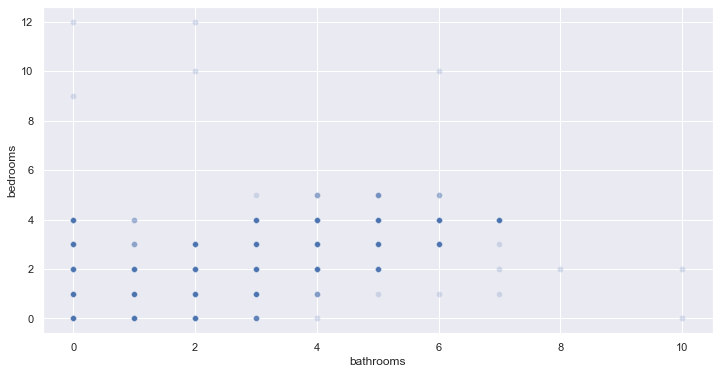

In [33]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=clean_data, x = "bathrooms", y="bedrooms", alpha = 0.2)

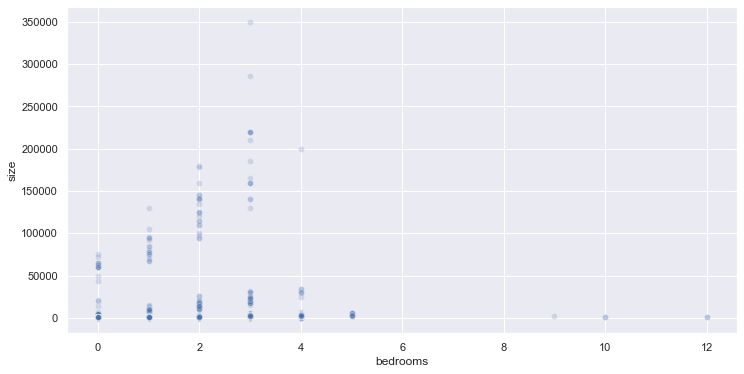

In [34]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=clean_data[clean_data["size"]<400_000], x = "bedrooms", y="size", alpha = 0.2)

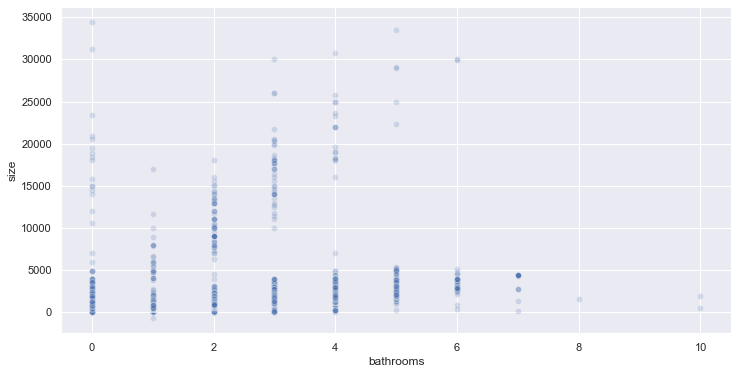

In [35]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=clean_data[clean_data["size"]<40_000], x = "bathrooms", y="size", alpha = 0.2)

### New Features

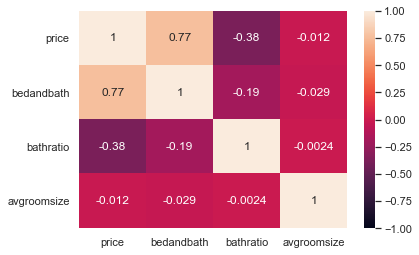

In [36]:
check = clean_data[["price"]].copy(deep=True)
check["bedandbath"] = clean_data["bathrooms"]+clean_data["bedrooms"]
check["bathratio"] = clean_data["bathrooms"]/(clean_data["bathrooms"]+clean_data["bedrooms"])
check["avgroomsize"] =clean_data["size"]/(clean_data["bathrooms"]+clean_data["bedrooms"])
check["bathratio"] = check["bathratio"].fillna(0)

sns.heatmap(check.corr(),vmin=-1,vmax=1,annot=True)

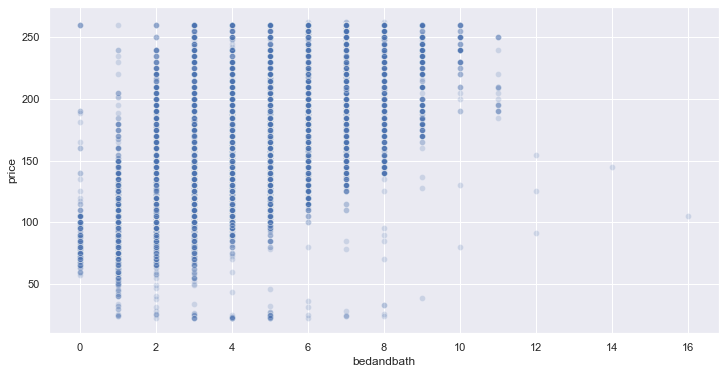

In [37]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = check["bedandbath"], y=check["price"], alpha = 0.2)        

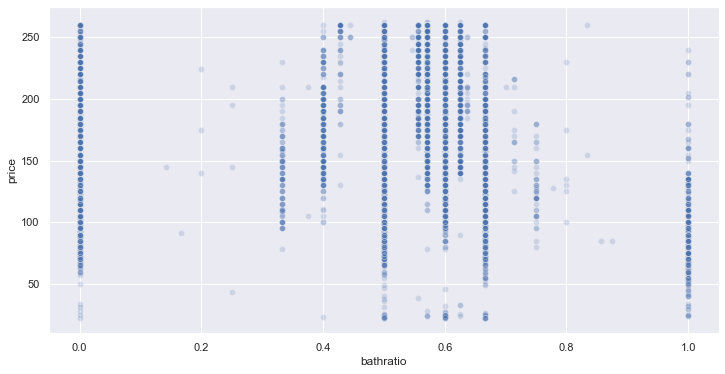

In [38]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = check["bathratio"], y=check["price"], alpha = 0.2) 


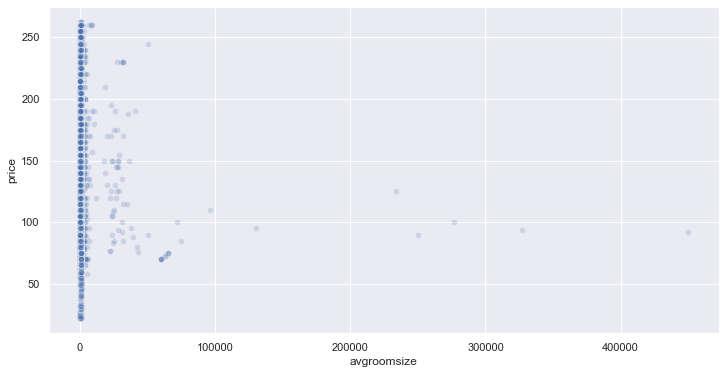

In [39]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = check["avgroomsize"], y=check["price"], alpha = 0.2) 


### Business Rules (Assumptions)

- An apartment cannot have more than 2 times the number bathrooms to bedrooms
- An apartment can have 0 bedrooms and a bathroom (loft apartment maybe)
- An apartment must have at least one bedroom or bathroom
- The size of an apartment must be greater than 0 and less than 400_000 

In [40]:
model_data = data.copy(deep = True).drop("building", axis =1)

model_data = model_data.loc[model_data["price"] <= (threshold*1000)]

model_data = model_data.loc[ (model_data["size"] > 0) & (model_data["size"] <= 400_000)] 

model_data = model_data.loc[ ((model_data["bathrooms"] <= (model_data["bedrooms"]*2))) | ((model_data["bathrooms"] ==1) & (model_data["bedrooms"]==0 ))]
model_data = model_data.loc[(model_data["bathrooms"]>0) | (model_data["bedrooms"]> 0)]

model_data["bathratio"] = model_data["bathrooms"]/(model_data["bathrooms"]+model_data["bedrooms"])
model_data["bathratio"] = model_data["bathratio"].fillna(0)

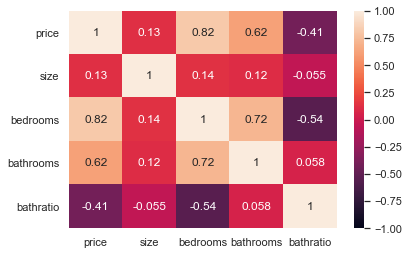

In [41]:
sns.heatmap(model_data.corr(),vmin=-1,vmax=1,annot=True)

In [42]:
print(f"Final Data Loss {data.shape[0]-model_data.shape[0]} ({(data.shape[0]-model_data.shape[0])/y.shape[0]})")


Final Data Loss 3417 (0.050918682104698465)


In [43]:
model_data.describe()

,price,size,bedrooms,bathrooms,bathratio
count,63690.000000,63690.000000,63690.000000,63690.000000,63690.000000
mean,132961.897879,1411.369113,1.584362,2.211273,0.605146
std,45100.384348,4409.906360,0.921695,1.080946,0.195696
min,22000.000000,1.000000,0.000000,0.000000,0.000000
25%,96000.000000,829.000000,1.000000,2.000000,0.500000
50%,125000.000000,1188.000000,2.000000,2.000000,0.600000
75%,160000.000000,1558.000000,2.000000,3.000000,0.666667
max,262500.000000,350000.000000,12.000000,7.000000,1.000000


In [44]:
model_data.isnull().sum()

neighbourhood    0
price            0
size             0
bedrooms         0
bathrooms        0
bathratio        0
dtype: int64

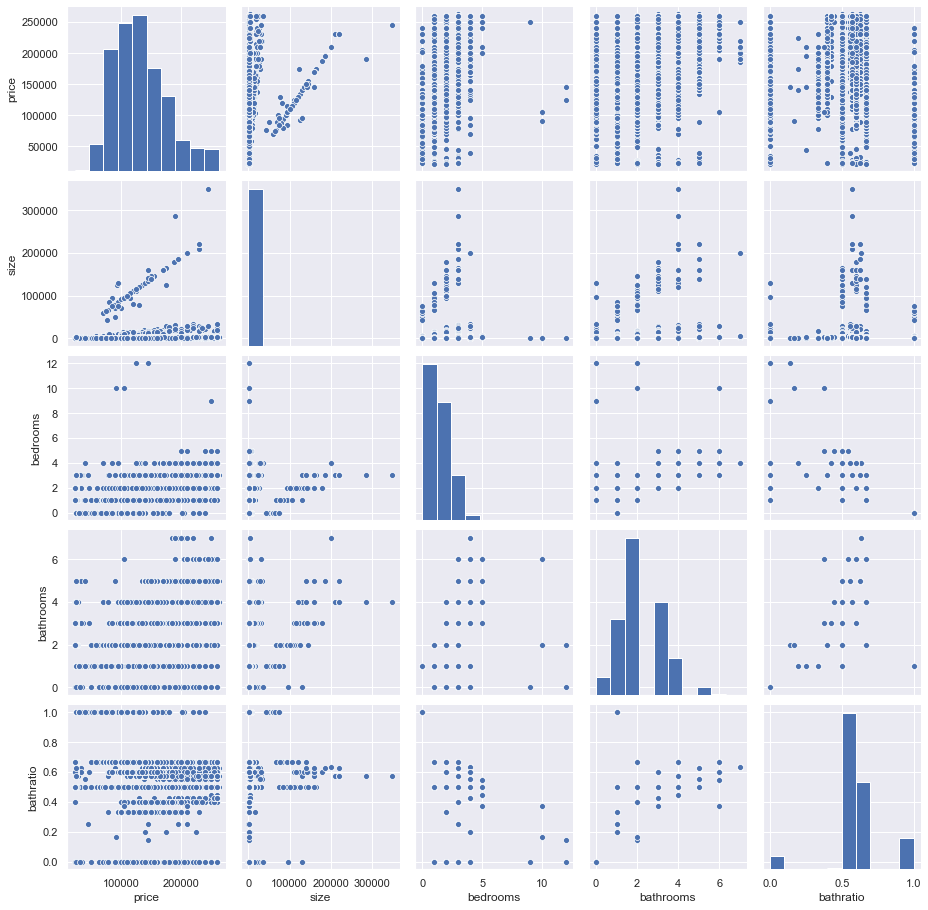

In [45]:
sns.pairplot(model_data)

## Train Gradient Boosted Regression

In order to as accurately as possible assess how the selected model will perform with real out of sample data. The data will be separated into 3 datasets, train and test and final_test. For this assessment 5 500 records are kept aside for test and another 5 500 for final_test. This is to prevent data leakage caused be using a test dataset to select a model.
In order to test model performanec during development, k-fold cross validation will be done.
Once a model is selected, the performance will be measured on the final test dataset and then selected final will be trained on the full dataset. 

In [46]:
train, test = train_test_split(model_data, test_size = 0.2, random_state = 101)

train.to_csv("train.csv")
test.to_csv("test.csv")

In [47]:
from sklearn.ensemble import  GradientBoostingRegressor
params = {"loss": "ls",
          "learning_rate": 0.01,
          "n_estimators": 1500,
          "subsample": 0.8,
          "min_samples_split": 3,
          "max_depth": 10,
          "verbose": 0,
          "random_state": 1,
          "max_features":0.6
         }


X = train[["neighbourhood", "size", "bedrooms", "bathrooms", "bathratio"]].copy(deep=True)
y = train[["price"]].copy(deep=True)

possible_categories = ('SNR', 'ZMS', 'PLY')
X["neighbourhood"] = X["neighbourhood"].astype(pd.CategoricalDtype(categories=possible_categories))
X = pd.get_dummies(X, columns=["neighbourhood"])

gbr = GradientBoostingRegressor(**params)


scores = cross_val_score(gbr, X, y.values.flatten(), scoring="neg_mean_absolute_error", cv=3, n_jobs=-1)
print(f"{scores.mean()} ({scores.std()})")



-12140.526344514508 (67.25742948819051)


In [48]:
gbr_fit = gbr.fit(X, y.values.flatten())

In [49]:
y_pred_train = gbr_fit.predict(X)
mean_absolute_error(y, y_pred_train)

10731.649894362132

In [50]:
test_X = test[["neighbourhood", "size", "bedrooms", "bathrooms", "bathratio"]].copy(deep=True)
test_y = test[["price"]]

test_X["neighbourhood"] = test_X["neighbourhood"].astype(pd.CategoricalDtype(categories=possible_categories))
test_X = pd.get_dummies(test_X, columns=['neighbourhood'])
    

y_pred = gbr_fit.predict(test_X)

mean_absolute_error(test_y, y_pred)

12057.565416402997

In [51]:
ind = gbr.feature_importances_.argsort()[::-1]
features = gbr.feature_importances_[ind]
cols = X.columns[ind]
for i in range(len(X.columns)):
    print(cols[i], features[i])

size 0.5863988177649402
bedrooms 0.2554749026649935
bathrooms 0.07120348359033592
bathratio 0.0402593856037546
neighbourhood_PLY 0.02803817933874095
neighbourhood_SNR 0.010074916772739207
neighbourhood_ZMS 0.008550314264495616


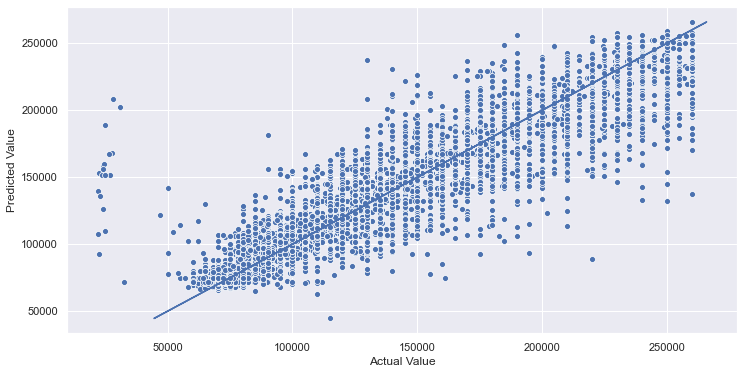

In [52]:
plt.figure(figsize=(12,6))
sns.scatterplot(test_y.values.flatten(), y_pred)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.plot(y_pred, y_pred)